# Machine learning - Instructor notebook
   
   - Dataset, RDD APIs
   - A dataframe is nothing but a table with columns, rows and headers
   - In this notebook, we will work through a dataset to demostrate spark's SQL-like abilities. We will also look at its machine learning capabilities in context of this dataset.
    
### Dataset
- The chosen dataset is that of Breast Cancer. This set is collected from digitized image of a fine needle aspirate (FNA) of a breast mass. For more information about this dataset, please visit https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
- Each row contains information about a single breast mass along with a diagnosis of malignant/benign for this mass
    
### Problem statement
- We need to learn patterns describing malignant and benign masses and need to be able to place any future samples in either of these buckets.  
- Thus, the problem is a classification one where given a set of probable results, we need to pick one result with confidance. 
    
### Solution
   We will go through the following steps:
   - Read data (Spark SQL)
   - Feature Engineering (Accumulators, Broadcasters, ml/mllib APIs)
   - Data Visualizations (PixieDust, Seaborn)
   - Modeling (Spark ML)
   - Evaluation and prediction (Spark ML)
   - Deployment (Watson ML repository)

In [1]:
from IPython.display import display
from IPython.core.display import HTML 

In [2]:
!pip install seaborn

#### Machine Learning process ###

<center><img width="600px" height="600px" src="https://raw.githubusercontent.com/martinkearn/Content/master/Blogs/Images/MLProcess.PNG"></center>

### Get dataset
!wget https://raw.githubusercontent.com/joshishwetha/dsx-spark/master/data.csv

In [45]:
!wget https://raw.githubusercontent.com/joshishwetha/dsx-spark/master/data.csv

--2017-04-26 00:21:31--  https://raw.githubusercontent.com/joshishwetha/dsx-spark/master/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125139 (122K) [text/plain]
Saving to: ‘data.csv.5’

100%[======================================>] 125,139     --.-K/s   in 0.006s  

2017-04-26 00:21:32 (21.2 MB/s) - ‘data.csv.5’ saved [125139/125139]



### Read dataset

#### copy and paste the following code
    data = spark.read.csv('data.csv',inferSchema='true',header='true')
    data = data.drop('_c32')

In [46]:
data = spark.read.csv('data.csv',inferSchema='true',header='true')
data = data.drop('_c32')

## Data Exploration ###

<center><img width="450px" height="450px" margin="auto" src="https://img.clipartfest.com/f92b25f421c985eed2ccb12cdb4cbf54_vector-clip-art-cartoon-safari-kids-cartoon-clipart_800-557.jpeg"></center>

#### Basic operations on dataframe 
- To view contents: df.show(), df.take(n)
- To transform columns: df.withColumn ("column_name","transformation")
- To rename columns: df.withColumnRenamed("old_name","new_name")

#### Print first 3 rows of the input dataset ###

    data.toPandas()[:3]

In [47]:
data.toPandas()[:3]

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


### Check datatypes
    data.dtypes

In [48]:
data.dtypes

[('id', 'int'),
 ('diagnosis', 'string'),
 ('radius_mean', 'double'),
 ('texture_mean', 'double'),
 ('perimeter_mean', 'double'),
 ('area_mean', 'double'),
 ('smoothness_mean', 'double'),
 ('compactness_mean', 'double'),
 ('concavity_mean', 'double'),
 ('concave points_mean', 'double'),
 ('symmetry_mean', 'double'),
 ('fractal_dimension_mean', 'double'),
 ('radius_se', 'double'),
 ('texture_se', 'double'),
 ('perimeter_se', 'double'),
 ('area_se', 'double'),
 ('smoothness_se', 'double'),
 ('compactness_se', 'double'),
 ('concavity_se', 'double'),
 ('concave points_se', 'double'),
 ('symmetry_se', 'double'),
 ('fractal_dimension_se', 'double'),
 ('radius_worst', 'double'),
 ('texture_worst', 'double'),
 ('perimeter_worst', 'double'),
 ('area_worst', 'double'),
 ('smoothness_worst', 'double'),
 ('compactness_worst', 'double'),
 ('concavity_worst', 'double'),
 ('concave points_worst', 'double'),
 ('symmetry_worst', 'double'),
 ('fractal_dimension_worst', 'double')]

#### Make sure the data types are correct ####

    from pyspark.sql.types import FloatType, StringType, IntegerType, DoubleType, ArrayType

    for col in data.columns:
        if col not in ['id','diagnosis']:
            data = data.withColumn(col,data[col].cast(FloatType()))

In [49]:
from pyspark.sql.types import FloatType, StringType, IntegerType, DoubleType, ArrayType

for col in data.columns:
    if col not in ['id','diagnosis']:
        data = data.withColumn(col,data[col].cast(FloatType()))

#### Replace null values with 0
    data = data.na.fill(0)

In [50]:
data = data.na.fill(0)

### SQL

#### Register dataframe as a temp table to query from (write sql on dataframes)
    data.registerTempTable('cancer_data')

In [51]:
data.registerTempTable('cancer_data')

#### Querying data
- NOTE that the returned object is another Dataframe
- One nice feature of the notebooks and python is that we can show it in a table via Pandas
- Remember to perform an action to get your results (sql queries are also transformations :))

    query = """
    select
        diagnosis ,
        count(1) as diagnosis_count
    from cancer_data
    group by diagnosis 
    """
    spark.sql(query).toPandas()


In [52]:
query = """
    select
        diagnosis ,
        count(1) as diagnosis_count
    from cancer_data
    group by diagnosis 
    """
spark.sql(query).toPandas()

,diagnosis,diagnosis_count
0,B,357
1,M,212


## Feature Engineering
   - Dataset = Features + target
   - Transforming features (categorical to numeric, continous to bins, scaling, normalization etc...)
   - Selecting a subset of columns for wide datasets
   - Exploding columns to make additional (synthetic features) for small datasets

### Feature set is numeric

##### Step 1: Make sure your target is numeric
- "target" is categorical (malignant/benign)
- Our encoding: 1 = malignant(M), 0 = Benign(B) using sql like "when" statement

### Review your data
#### Sample your data to view what it looks like before we make changes to the target column

    data.select('diagnosis','radius_se').show(3)

In [53]:
data.select('diagnosis','radius_se').show(3)

+---------+---------+
|diagnosis|radius_se|
+---------+---------+
|        M|    1.095|
|        M|   0.5435|
|        M|   0.7456|
+---------+---------+
only showing top 3 rows



### Make label numeric

##### copy and paste to run code
    import  pyspark.sql.functions as F

    data = data.withColumn('diagnosis',F.when(data.diagnosis=='M',1).otherwise(0))
    data.toPandas().head(3)

In [54]:
import  pyspark.sql.functions as F

data = data.withColumn('diagnosis',F.when(data.diagnosis=='M',1).otherwise(0))
data.toPandas().head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.990000,10.38,122.800003,1001,0.11840,0.27760,0.3001,0.14710,...,25.379999,17.330000,184.600006,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.570000,17.77,132.899994,1326,0.08474,0.07864,0.0869,0.07017,...,24.990000,23.410000,158.800003,1956,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.690001,21.25,130.000000,1203,0.10960,0.15990,0.1974,0.12790,...,23.570000,25.530001,152.500000,1709,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


#### Rename column from "diagnosis" to "label"

    data = data.withColumnRenamed('diagnosis','label')

In [55]:
data = data.withColumnRenamed('diagnosis','label')

***********************************************************************************

###   Detour  
- Feature engineering is a major task and often involves complicated scripts

What happens when
   - Have custom script based on other datasets/static variables?
   - I want to port over a current script to spark ?

### Accumulators, Broadcasters
- One of the most basic things in scripts are variables (data and metadata). 
- Data vars = DataFrames/RDDs in spark
- Metadata vars = Accumulators/broadcasters 
   
- Metadata vars are not straightforward in the distributed world


##### Accumulators
   - Global variables which can be written into
   
##### Broadcasters
   - Global variables to be read from 
************************************************************************************************

#### Lets run a simple accumulator
- Problem: Count the number of benign and malignant cases

In [56]:
def count_labels(row):
    global benign, malignant
    if row.label==1:
        malignant.add(1)
    else:
        benign.add(1)

#### copy and run this code
    benign = sc.accumulator(0)
    malignant = sc.accumulator(0)

    data.rdd.foreach(count_labels)

    benign.value, malignant.value

In [57]:
benign = sc.accumulator(0)
malignant = sc.accumulator(0)

data.rdd.foreach(count_labels)

benign.value, malignant.value

(357, 212)

#### Broadcast the data variable so that each executor has its own version of it
   - This way, it does need not be shipped to the executor with every call
   - Saves network bandwidth

### Collect statistics for your dataset ###
- Collect statistics for mean/std
- store it in a variable called "df"


        df = data.describe()
        df.toPandas()

In [58]:
df = data.describe()
df.toPandas()

,summary,id,label,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,count,569,569,569,569,569,569,569,569,569,...,569,569,569,569,569,569,569,569,569,569
1,mean,3.0371831432337433E7,0.37258347978910367,14.127291743072348,19.289648528677297,91.96903329993384,654.889103814043,0.09636028129312821,0.10434098429781481,0.08879931578830029,...,16.269189776770887,25.67722316534113,107.26121279644421,880.5831290514901,0.13236859435565862,0.25426504394016597,0.2721884833807977,0.11460622294146325,0.2900755708948799,0.08394581713895387
2,stddev,1.2502058561222367E8,0.4839179564031687,3.524048812967195,4.301035792275387,24.298980946187076,351.91412886139733,0.014064128011679866,0.05281275807458227,0.07971980885275734,...,4.8332415912724365,6.146257611231105,33.602542264508905,569.3569923849643,0.022832429559187094,0.15733648854662943,0.20862428007810724,0.06573234105890066,0.06186746818484165,0.01806126727675421
3,min,8670,0,6.981,9.71,43.79,143.5,0.05263,0.01938,0.0,...,7.93,12.02,50.41,185.2,0.07117,0.02729,0.0,0.0,0.1565,0.05504
4,max,911320502,1,28.11,39.28,188.5,2501.0,0.1634,0.3454,0.4268,...,36.04,49.54,251.2,4254.0,0.2226,1.058,1.252,0.291,0.6638,0.2075


#### Calculate correlations of each columns w.r.t the target
- Change to do this in spark



#### Select a subset of columns
- Remove columns conveying very little information
   - Zero variance columns
   - Low correlation columns

In [59]:
df = data.toPandas()
col_corr = sorted(df.corr()['label'].to_dict().items(),key=lambda x:x[1],reverse=True)
for col in col_corr[-5:]:
    if col[0]!='id':
        data = data.drop(col[0])

- Remove columns with low correlation, such columns contribute to very little information
- Caution: Be wary of multicolinearity ("leaky" columns)

## Lets do some graphs!

###  Here, we look at the columns and their correlations with the target variable.
- We use PixieDust (charting library) for quick charts
- Also takes RDDs as inputs, most of the other charting librabries take pandas dataframes as inputs


##### copy and run code from here
    import pixiedust
    import pandas as pd
    
    df = pd.DataFrame(col_corr)
    df = df.dropna()
    df.columns = ['name','correlation']
    viz_spark_df = sqlContext.createDataFrame(df)

   
    display(viz_spark_df)

In [60]:
import pixiedust
import pandas as pd

df = pd.DataFrame(col_corr)
df = df.dropna()
df.columns = ['name','correlation']
viz_spark_df = sqlContext.createDataFrame(df)


display(viz_spark_df)

### Visualize correlations ####
 - Useful for datasets with small number of columns
 - A heatmap is useful to visualize how variables are related to each other (and not just the target)
 - Very useful while doing NLP applications to visualize similarity between documents (after using TFIDF)
 

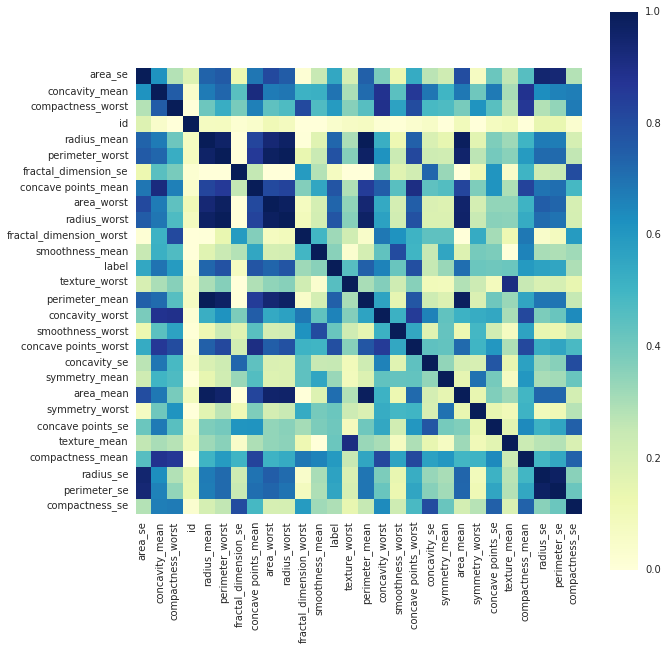

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.mllib.stat import Statistics

plt.style.use('ggplot')
values = data.rdd.map(lambda x:list(x.asDict().values()))
corr_values = Statistics.corr(values)
names = data.rdd.map(lambda x:list(x.asDict().keys())).first()

plt.figure(figsize=(10,10))
sns.set_style("darkgrid")
sns.heatmap(corr_values,xticklabels=names,yticklabels=names,square=True,vmin=0, vmax=1,
                cmap="YlGnBu")

### Vizualize existing classes

### PCA  - Dimensionality Reduction 
 - Very handy for visualization!

In [62]:
###### PCA Visualize data ######
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import UserDefinedFunction
from pyspark.ml.feature import VectorAssembler 

feature_cols = list(filter(lambda x:x not in ['id','label','dummy'],data.columns))
assembler = VectorAssembler(inputCols=feature_cols,outputCol='features')
df = assembler.transform(data)

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)

pca_result = model.transform(df)
result = pca_result.select("pcaFeatures")


### UserDefined Functions

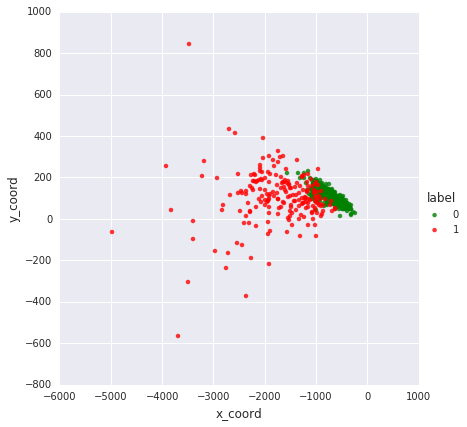

In [63]:
import regex

def g(point,co_ord):
    if co_ord=='x':
        value = regex.split('\s+',point)[0][1:]
    else:
        value =  regex.split('\s+',point)[1][:-1]
    return value

get_x_coord = UserDefinedFunction(lambda point:g(point,'x'), StringType())
get_y_coord = UserDefinedFunction(lambda point:g(point,'y'), StringType())
convert_to_string = UserDefinedFunction(lambda point:str(point.toArray()),StringType())

pca_result = pca_result.withColumn('pcaFeatures_string',convert_to_string(pca_result['pcaFeatures']))
pca_result = pca_result.withColumn('x_coord',get_x_coord(pca_result['pcaFeatures_string']))\
                       .withColumn('y_coord',get_y_coord(pca_result['pcaFeatures_string']))\
                      
pca_result = pca_result.withColumn('x_coord',pca_result.x_coord.cast(FloatType()))\
                       .withColumn('y_coord',pca_result.y_coord.cast(FloatType()))
    
viz_df = pca_result.select('x_coord','y_coord','label').toPandas()
a = sns.lmplot(x='x_coord',y='y_coord',hue='label',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=6,aspect=1)

## We are all set to do some machine learning!

<center><img width="350px" height="350px" margin="auto" src="http://www.clipartkid.com/images/127/cartoon-explorer-characters-vectors-6cbSmI-clipart.jpg"></center>

## Module layout
##### It divides into two packages:
- spark.mllib contains the original API built on top of RDDs.
- spark.ml provides higher-level API built on top of DataFrames for constructing ML pipelines.
- Using spark.ml is recommended because with DataFrames the API is more versatile and flexible. But we will keep supporting spark.mllib along with the development of spark.ml. Users should be comfortable using spark.mllib features and expect more features coming.

    
    
#### A common receipe
- Make sure your data is numeric 
- Collect feature columns
- Define transformations (Vector Indexer, Encoder)
- Assemble columns into a single Vector column (VectorAssembler)
- Split data into test and train
- Define pipelines and estimators

### Prepare the dataset for machine learning
    - Split data between test and train (70/30 split)
    - Apply logistic regression and decision tree classifiers

#### Convert 'label' to DoubleType()


In [29]:
data = data.withColumn('label',data['label'].cast(DoubleType()))

#### Split dataset into test and train sets (70/30) splits

In [30]:
train, test = data.randomSplit([0.7,0.3])

#### Count number of records in test and train sets

In [31]:
train.count(), test.count()

(407, 162)

### Machine learning Pipelines
- Easy to use API
- Define stages to transform your dataset
- Select any estimator (model) for prediction 
- Each pipeline will model a single estimator onto your model


<center><img src="https://image.slidesharecdn.com/mlwithapachespark-2-160818115257/95/introduction-to-ml-with-apache-spark-mllib-47-638.jpg?cb=1490306278" width="500px" height="500px"></center>

In [32]:
from pyspark.ml.pipeline import Pipeline

#### Define Assembler to combine feature into a single vetor (feature vector! :) )

In [33]:
from pyspark.ml.linalg import Vectors #linear algebra package, has matrices, arrays, Vectors (dense and sparse)
from pyspark.ml.feature import VectorAssembler 

feature_cols = list(filter(lambda x:x not in ['id','label'],data.columns))
assembler = VectorAssembler(inputCols=feature_cols,outputCol='features')

## Classification Pipelines 
- Logistic Regression
- Tree based classifier

<center><img src="https://codesachin.files.wordpress.com/2015/08/linearly_separable_4.png"></center>

In [34]:
#### Classification metrics ####
def calc_metrics(results):
    metrics = {}
    metrics['tp_0'] = results.filter((results.label==0)&(results.prediction==0)).count()
    metrics['fn_0'] = results.filter((results.label==0)&(results.prediction==1)).count()
    metrics['tn_0'] = results.filter((results.label==1)&(results.prediction==1)).count()
    metrics['fp_0'] = results.filter((results.label==1)&(results.prediction==0)).count()
    
    metrics['tp_1'] = results.filter((results.label==1)&(results.prediction==1)).count()
    metrics['fn_1'] = results.filter((results.label==1)&(results.prediction==0)).count()
    metrics['tn_1'] = results.filter((results.label==0)&(results.prediction==0)).count()
    metrics['fp_1'] = results.filter((results.label==0)&(results.prediction==1)).count()
    
    return metrics
        
### calc precision & recall ###
def precision_recall(results):
    items = calc_metrics(results)
    pre_0 = items['tp_0']/float((items['tp_0']+items['fp_0']))
    pre_1 = items['tp_1']/float((items['tp_1']+items['fp_1']))
    
    recall_0 = items['tp_0']/float((items['tp_0']+items['fn_0']))
    recall_1 = items['tp_1']/float((items['tp_1']+items['fn_1']))
    
    return {'pre_0':pre_0, 'recall_0':recall_0,'pre_1':pre_1,'recall_1':recall_1}

##### Logistic regression #####

In [72]:
from pyspark.ml.classification import LogisticRegression

#define estimator and fit data
estimator = LogisticRegression()
pipeline = Pipeline(stages=[assembler,estimator])
lr_model = pipeline.fit(train)

#get results
results = lr_model.transform(test)

In [66]:
results.printSchema()

root
 |-- id: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- radius_mean: float (nullable = false)
 |-- perimeter_mean: float (nullable = false)
 |-- area_mean: float (nullable = false)
 |-- compactness_mean: float (nullable = false)
 |-- concavity_mean: float (nullable = false)
 |-- concave points_mean: float (nullable = false)
 |-- radius_se: float (nullable = false)
 |-- perimeter_se: float (nullable = false)
 |-- area_se: float (nullable = false)
 |-- radius_worst: float (nullable = false)
 |-- texture_worst: float (nullable = false)
 |-- perimeter_worst: float (nullable = false)
 |-- area_worst: float (nullable = false)
 |-- smoothness_worst: float (nullable = false)
 |-- compactness_worst: float (nullable = false)
 |-- concavity_worst: float (nullable = false)
 |-- concave points_worst: float (nullable = false)
 |-- symmetry_worst: float (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: 

In [68]:
results.select('id','features','label','probability','prediction').show()

+------+--------------------+-----+--------------------+----------+
|    id|            features|label|         probability|prediction|
+------+--------------------+-----+--------------------+----------+
|  9047|[12.9399995803833...|  0.0|[0.99549549549549...|       0.0|
| 85715|[13.1700000762939...|  1.0|           [0.0,1.0]|       1.0|
| 86211|[12.1800003051757...|  0.0|[0.99549549549549...|       0.0|
| 86408|[12.6300001144409...|  0.0|[0.99549549549549...|       0.0|
| 86517|[18.6599998474121...|  1.0|           [0.0,1.0]|       1.0|
| 87106|[11.1499996185302...|  0.0|[0.99549549549549...|       0.0|
| 87163|[13.4300003051757...|  1.0|           [0.0,1.0]|       1.0|
| 87930|[12.4700002670288...|  0.0|[0.99549549549549...|       0.0|
| 89122|[19.3999996185302...|  1.0|           [0.0,1.0]|       1.0|
| 89346|[9.0,56.360000610...|  0.0|[0.99549549549549...|       0.0|
| 89812|[23.5100002288818...|  1.0|           [0.0,1.0]|       1.0|
| 89869|[14.7600002288818...|  0.0|           [1

In [70]:
results.select('probability','prediction','label').take(3)

[Row(probability=DenseVector([0.9955, 0.0045]), prediction=0.0, label=0.0),
 Row(probability=DenseVector([0.0, 1.0]), prediction=1.0, label=1.0),
 Row(probability=DenseVector([0.9955, 0.0045]), prediction=0.0, label=0.0)]

### Evaluation

- Classification models work towards making a Yes/No decision
- Metrics to evaluate the model: Precision/Recall, AUC


<center><img width="500px" height="500px" src="http://opexanalytics.com/cnt/uploads/2016/01/Red-Fish-High-Recall.jpg"></center>

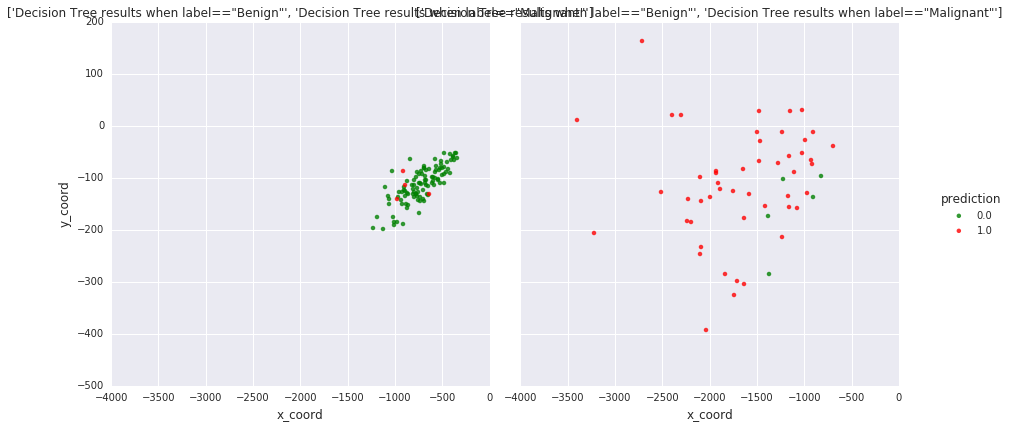

In [36]:
### Visualize results from logistic regression ###
pca_subset = pca_result.select('id','features','x_coord','y_coord')
viz_df = pca_subset.join(results,on=['id','features']).select('x_coord','y_coord','prediction','label')
viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

a = sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='label',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=6,aspect=1)
a.set_titles(col_template=['Decision Tree results when label=="Benign"','Decision Tree results when label=="Malignant"'])

#### Tree classifier ####
- Can you do the same using a decicion tree classifier?

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier
# define estimator and fit data
estimator = DecisionTreeClassifier()
pipeline = Pipeline(stages=[assembler,estimator])
tree_model = pipeline.fit(train)

# get results
results = tree_model.transform(test)
precision_recall(results)

{'pre_0': 0.9809523809523809,
 'pre_1': 0.9122807017543859,
 'recall_0': 0.9537037037037037,
 'recall_1': 0.9629629629629629}

### Visualize the results of tree classifier

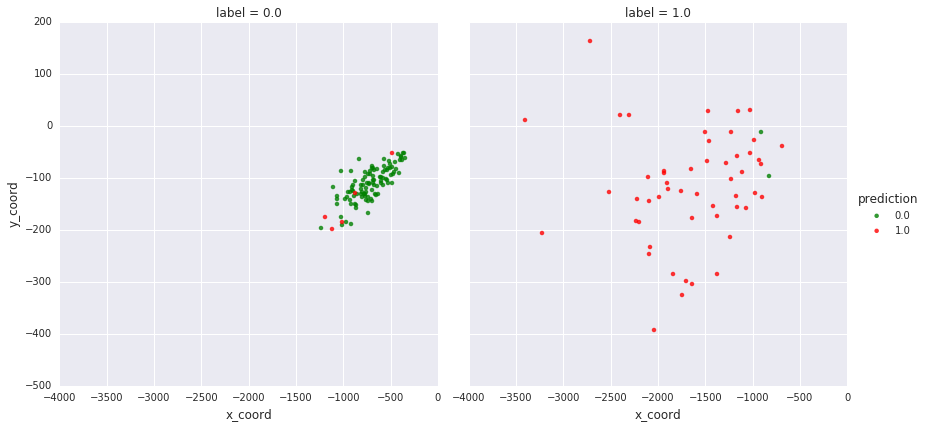

In [38]:
### Visualize the results of tree classifier ###
pca_subset = pca_result.select('ID','features','x_coord','y_coord')
viz_df = pca_subset.join(results,on=['ID','features']).select('x_coord','y_coord','prediction','label')
viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

a = sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='label',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=6,aspect=1)

### Clustering Pipeline
- K-means clustering

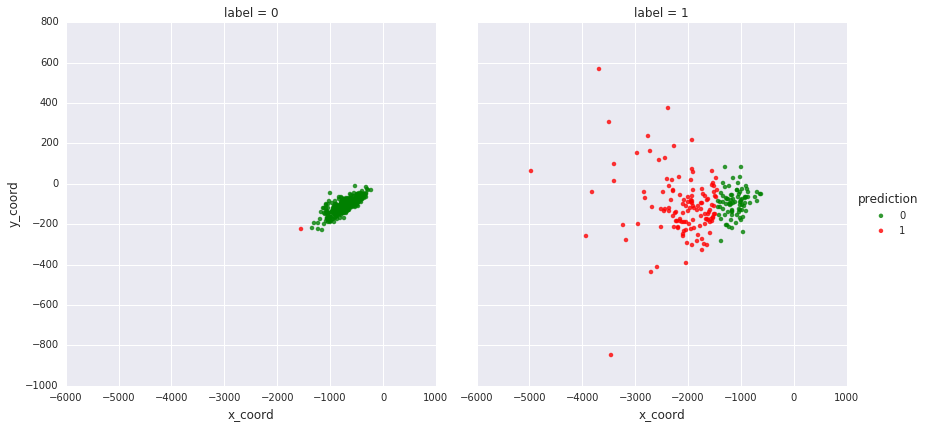

In [39]:
######## Kmeans clustering, join to the PCA set #########
from numpy import array
from math import sqrt
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2,featuresCol='features')
model = kmeans.fit(pca_result)
centers = model.clusterCenters()
kmeans_result = model.transform(pca_result).select('id','features','prediction')

viz_df = pca_result.join(kmeans_result,on=['id','features'],how='inner')\
                   .select('id','features','x_coord','y_coord','prediction','label')

viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='label',data=viz_df,
           fit_reg=False,palette={1:'red',0:'green'},size=6,aspect=1)

### Deploy to Cloud by using Watson Machine Learning Repo
   Please follow demonstration! :D


In [41]:
### Setup keys for authentication ###
import urllib3, requests, json

### Authenticate ML repo ###
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

ml_repository_client = MLRepositoryClient(service_path)
ml_repository_client.authorize(username, password)

### Save model ###
model_artifact_lr = MLRepositoryArtifact(lr_model, training_data=train, name="Logistic Regression Classifer")
saved_model = ml_repository_client.models.save(model_artifact_lr)

#### load model ###
loadedModelArtifact = ml_repository_client.models.get(saved_model.uid)

In [42]:
### make predictions ####
predictions = loadedModelArtifact.model_instance().transform(test)
precision_recall(predictions)

In [43]:
### get token ###
headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(username, password))
url = '{}/v2/identity/token'.format(service_path)
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')

In [44]:
### deploy model ###
endpoint_online = service_path + "/v2/online/deployments/"
header_online = {'Content-Type': 'application/json', 'Authorization': mltoken}
payload_online = {"artifactVersionHref": saved_model.meta.prop("modelVersionHref"), "name": "Product Line Prediction"}

response_online = requests.post(endpoint_online, json=payload_online, headers=header_online)
scoring_href = json.loads(response_online.text).get('entity').get('scoringHref')

In [ ]:
### online scoring ####
scoring_href = "https://ibm-watson-ml.mybluemix.net/32768/v2/scoring/1751"
payload_scoring = {"record":list(tuple(t.take(5)[-1]))}
response_scoring = requests.put(scoring_href, json=payload_scoring, headers=header_online)